In [1]:
import pandas as pd
import numpy as np

import matplotlib
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./input/train_fe.csv')

In [3]:
train = train.drop(train.columns[0], axis=1)

In [4]:
X = train.drop('item_cnt_day', axis=1)
y = train['item_cnt_day']


In [5]:
def objectiveXGB(trial: Trial, X, y):

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method' : 'gpu_hist',
        'predictor' : 'gpu_predictor',
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('aplha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    model = xgb.XGBRegressor(**params)
    xgb_model = model.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
    score = mean_squared_error(xgb_model.predict(X_test), y_test, squared=False)

    return score

In [6]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objectiveXGB(trial, X, y), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.values, study.best_trial.params))

[I 2022-01-19 13:45:45,912] A new study created in memory with name: no-name-3f5a63da-383f-4a64-8531-88bcb7d9f360
[I 2022-01-19 13:46:14,488] Trial 0 finished with value: 2.336781115774806 and parameters: {'n_estimators': 1312, 'max_depth': 12, 'min_child_weight': 140, 'gamma': 2, 'colsample_bytree': 0.9, 'lambda': 1.5588298525635247, 'aplha': 7.652254635087943, 'subsample': 1.0}. Best is trial 0 with value: 2.336781115774806.
[I 2022-01-19 13:46:48,534] Trial 1 finished with value: 2.170374903556052 and parameters: {'n_estimators': 2762, 'max_depth': 8, 'min_child_weight': 66, 'gamma': 2, 'colsample_bytree': 1.0, 'lambda': 0.04047732187052838, 'aplha': 0.0015399690344961461, 'subsample': 0.8}. Best is trial 1 with value: 2.170374903556052.
[I 2022-01-19 13:47:12,670] Trial 2 finished with value: 2.0237071476843584 and parameters: {'n_estimators': 773, 'max_depth': 13, 'min_child_weight': 43, 'gamma': 1, 'colsample_bytree': 0.5, 'lambda': 0.004460092355154895, 'aplha': 4.63764040777003

Best trial: score [1.5485223395516305],
params {'n_estimators': 1324, 'max_depth': 16, 'min_child_weight': 272, 'gamma': 3, 'colsample_bytree': 0.9, 'lambda': 6.387911137972239, 'aplha': 0.0010061166921427533, 'subsample': 0.7}


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

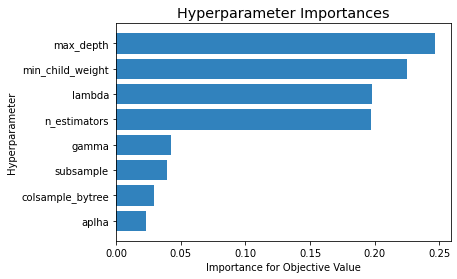

In [7]:
optuna.visualization.matplotlib.plot_param_importances(study)

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

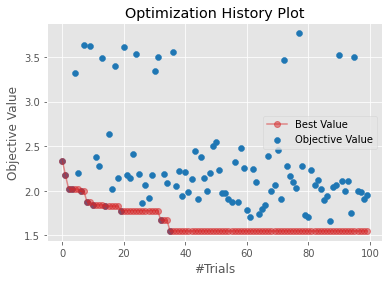

In [8]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<https://dacon.io/codeshare/2876>
<https://www.kaggle.com/ssooni/xgboost-lgbm-optuna/notebook>
<https://ssoonidev.tistory.com/107#recentComments>
